In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')
sys.path.append('../src')

import pandas as pd
import numpy as np

from loading import Loader
from preprocessing import Preprocessor

In [3]:
data_loader = Loader()
data = data_loader.load_data()

In [ ]:
preprocessor = Preprocessor()
preprocessor.preprocess(data)

# Loading data

In [9]:
data_loader = Loader(sample=1_000_000)
data = data_loader.load_data('../data/inputs/transactions_dataset.csv')

In [10]:
data.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051


# Data Quality checks

## Quantity

In [24]:
(data['quantity'] <= 0).sum()

0

<AxesSubplot:ylabel='Frequency'>

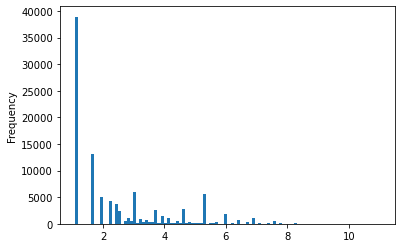

In [30]:
np.log(data['quantity']).plot(kind='hist', bins=100)

## Sales Net

In [31]:
(data['sales_net'] <= 0).sum()

4654

<AxesSubplot:ylabel='Frequency'>

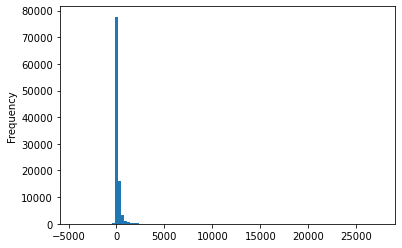

In [33]:
data['sales_net'].plot(kind='hist', bins=100)

## Dates

In [10]:
invoices_date = pd.to_datetime(data['date_invoice'])
print(max(invoices_date))
print(min(invoices_date))

2021-07-13 00:00:00
2016-10-12 00:00:00


In [11]:
orders_date = pd.to_datetime(data['date_order'])
print(max(orders_date))
print(min(orders_date))

2019-09-22 00:00:00
2017-09-22 00:00:00


## Order Channel

In [40]:
data['order_channel'].unique()

array(['online', 'at the store', 'by phone',
       'during the visit of a sales rep', 'other'], dtype=object)

# Sales Cycle Analysis

In [5]:
def avg_date_diff(x):
    # Integer number of Days
    return pd.Timedelta(np.diff(x).mean()).total_seconds()/(60*60*24)


In [6]:
data['date_order'] = pd.to_datetime(data['date_order'])

In [7]:
data = data.sort_values('date_order')
test = data.groupby(by=['client_id'])['date_order'].agg(['size', 'min', 'max', avg_date_diff]).reset_index()

/var/folders/4b/dwg2nq6d56bdx_qd1pqxp_800000gn/T/ipykernel_26839/2249865063.py:3: RuntimeWarning: Mean of empty slice.
  return pd.Timedelta(np.diff(x).mean()).total_seconds()/(60*60*24)
/Users/henrique/miniforge3/envs/bcg/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [27]:
test.loc[(test['avg_date_diff'] >= 0) & (test['avg_date_diff'] < 10), 'frequency_category'] = 'freq'
test.loc[(test['avg_date_diff'] >= 10) & (test['avg_date_diff'] < 35), 'frequency_category'] = 'med'
test.loc[(test['avg_date_diff'] >= 35) | (test['avg_date_diff'] == 0), 'frequency_category'] = 'infreq'

In [9]:
test.to_csv('intermediate_step.csv')

In [3]:
test = pd.read_csv('intermediate_step.csv', index_col=0)

In [5]:
test.loc[test['frequency_category']!='infreq', :]

,client_id,size,min,avg_date_diff,frequency_category
0,6,40,2017-10-27,16.794872,med
1,7,15,2018-07-16,11.500000,med
2,14,12762,2017-09-25,0.056814,freq
3,18,2224,2017-09-26,0.322087,freq
4,25,4,2018-10-10,0.000000,freq
...,...,...,...,...,...
170582,2274437,2,2018-04-24,0.000000,freq
170583,2274440,111,2017-09-28,6.490909,freq
170584,2274456,22,2019-08-26,0.333333,freq
170587,2274508,8,2017-10-18,0.000000,freq


<AxesSubplot:xlabel='avg_date_diff', ylabel='Count'>

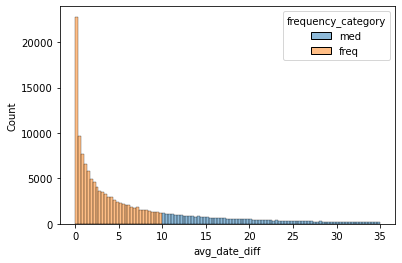

In [12]:
import seaborn as sns

sns.histplot(test.loc[test['frequency_category']!='infreq', :], x='avg_date_diff', hue='frequency_category')

In [22]:
from datetime import datetime, timedelta
datetime.strptime('2019-09-22', '%Y-%m-%d') - timedelta(20)

datetime.datetime(2019, 9, 2, 0, 0)

In [38]:
from datetime import datetime
test['is_churn'] = 0
test.loc[(test['frequency_category'] == 'freq') & (test['max'] < datetime.strptime('2019-09-22', '%Y-%m-%d') - timedelta(40)), 'is_churn'] = 1
test.loc[(test['frequency_category'] == 'med') & (test['max'] < datetime.strptime('2019-09-22', '%Y-%m-%d') - timedelta(100)), 'is_churn'] = 1
test.loc[(test['frequency_category'] == 'infreq') & (test['max'] < datetime.strptime('2019-09-22', '%Y-%m-%d') - timedelta(400)), 'is_churn'] = 1

In [39]:
print((test['is_churn'] == 1).sum())
print((test['is_churn'] == 1).sum()/170589)

58316
0.34185088135811803


# Feature engineering

In [45]:
data['date_order'] = pd.to_datetime(data['date_order'])
data = data.sort_values('date_order')

In [58]:
def purchase_frequency(dates):
    return pd.Timedelta(np.diff(dates).mean()).total_seconds()/(60*60*24)

def time_delay(dates, n=1):
    try:
        return pd.Timedelta(dates.iloc[-n] - dates.iloc[-n-1]).total_seconds()/(60*60*24)
    except IndexError:
        return np.nan
def last(sequence, n=1):
    try:
        return sequence.iloc[-n]
    except IndexError:
        return np.nan

In [59]:
from functools import partial

In [60]:
data.groupby(by='client_id', as_index=False).agg(
    mean_qty=('quantity', 'mean'),
    max_qty=('quantity', 'max'),
    min_qty=('quantity', 'min'),
    std_qty=('quantity', 'std'),
    last_qty_1=('quantity', partial(last, n=1)),
    last_qty_2=('quantity', partial(last, n=2)),
    last_qty_3=('quantity', partial(last, n=3)),
    last_qty_4=('quantity', partial(last, n=4)),
    mean_sales=('sales_net', 'mean'),
    max_sales=('sales_net', 'max'),
    min_sales=('sales_net', 'min'),
    std_sales=('sales_net', 'std'),
    last_sales_1=('sales_net', partial(last, n=1)),
    last_sales_2=('sales_net', partial(last, n=2)),
    last_sales_3=('sales_net', partial(last, n=3)),
    last_sales_4=('sales_net', partial(last, n=4)),
    n_branch=('branch_id', 'nunique'),
    n_product=('product_id', 'nunique'),
    purchase_freq=('date_order', purchase_frequency),
    delay_purchase_n1=('date_order', partial(time_delay, n=1)),
    delay_purchase_n2=('date_order', partial(time_delay, n=2)),
    delay_purchase_n3=('date_order', partial(time_delay, n=3)),
    delay_purchase_n4=('date_order', partial(time_delay, n=4)),
)

/var/folders/4b/dwg2nq6d56bdx_qd1pqxp_800000gn/T/ipykernel_28577/416716195.py:2: RuntimeWarning: Mean of empty slice.
  return pd.Timedelta(np.diff(dates).mean()).total_seconds()/(60*60*24)
/Users/henrique/miniforge3/envs/bcg/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: divide by zero encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


,client_id,mean_qty,max_qty,min_qty,std_qty,last_qty_1,last_qty_2,last_qty_3,last_qty_4,mean_sales,...,last_sales_2,last_sales_3,last_sales_4,n_branch,n_product,purchase_freq,delay_purchase_n1,delay_purchase_n2,delay_purchase_n3,delay_purchase_n4
0,14,374.132867,7201,3,1082.141673,4801,3.0,4801.0,4801.0,165.851359,...,222.621600,129.673410,129.673410,3,248,0.108772,0.0,0.0,0.0,0.0
1,18,30.666667,401,3,84.053123,3,31.0,3.0,11.0,52.399015,...,18.956293,12.088800,41.370560,1,22,0.782609,5.0,0.0,0.0,0.0
2,40,6.666667,13,3,3.444803,5,13.0,7.0,3.0,112.776411,...,105.267933,64.786400,47.527200,1,5,0.000000,0.0,0.0,0.0,0.0
3,56,11.000000,11,11,NaN,11,NaN,NaN,NaN,-8.399600,...,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,118,3.000000,3,3,NaN,3,NaN,NaN,NaN,0.110400,...,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58169,2274272,28.400000,201,3,61.738157,41,3.0,201.0,3.0,20.717820,...,18.657600,10.762344,29.587200,1,9,3.111111,0.0,0.0,4.0,8.0
58170,2274299,459.857143,1601,3,536.385256,3,11.0,401.0,401.0,73.140457,...,142.752720,22.319660,37.039568,1,7,3.000000,13.0,5.0,0.0,0.0
58171,2274322,7.000000,11,3,5.656854,3,11.0,NaN,NaN,22.770920,...,36.351040,NaN,NaN,1,2,0.000000,0.0,NaN,NaN,NaN
58172,2274410,467.666667,1001,201,461.880215,201,201.0,1001.0,NaN,127.927251,...,13.184796,361.258498,NaN,1,3,0.500000,0.0,1.0,NaN,NaN


In [61]:
data[data['client_id'] == 56]

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
961187,2017-10-26,2017-10-26,3000784,56,-8.3996,11,at the store,8488
